# DReS-FL Experiment 

- K = 1
- T = 1
- input dimension = [2, 3, 4, 5, 6, 7, 8, 9, 10]
- linear regression
- w = [1 1]
- finite field size = 23
- inputs are selected from {0, 1}
- no relationship between x and y
- the gradient is supposed to be revealed at the end of each training round

Basically, our objective function is $l = (y - xw)^2$ and our gradient is $g = -2(xy - x^2w)$ 

In [1]:
import numpy as np
from lcc.polynomials import LCCPoly, InterpolatedPoly
from mutual_information.estimators.neural.benchmark import neural_estimator_benchmark

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
def create_encoded_dataset(encoded_data_pol, data_size, encoded_label_pol, alpha):
    encoded_data = np.empty((len(encoded_data_pol), *data_size)) 
    encoded_label = np.empty((len(encoded_label_pol), 1))
    for idx, (data_pol, label_pol) in enumerate(zip(encoded_data_pol, encoded_label_pol)):
        encoded_data[idx] = data_pol(alpha)
        encoded_label[idx][0] = label_pol(alpha)
    return encoded_data, encoded_label

def calculate_gradient_samplewise(encoded_data, encoded_label, curr_weight, p):
    # g = -2(xy - x^2w)
    gradient = np.empty((encoded_data.shape[0], *curr_weight.shape))
    for idx in range(encoded_data.shape[0]):
        data, label = encoded_data[idx], encoded_label[idx]
        gradient[idx] = (label - (data.T @ curr_weight)[0][0]) % p
        gradient[idx] = (data * gradient[idx]) % p
        gradient[idx] = (-2 * gradient[idx]) % p
    gradient = gradient.astype(int)
    return gradient

def main_mi_calculation(data_range, prime, para_param, priv_param, num_of_samples, beta_arr, alpha_arr, weight, feature_size):
    secret_data = np.random.randint(low=0, high=data_range, size=(num_of_samples, feature_size, 1))
    secret_label = np.random.randint(low=0, high=data_range, size=(num_of_samples, 1))
    encoded_secret_data_pol = [LCCPoly(beta_arr, [x], para_param, priv_param, prime, size=(feature_size, 1)) for x in secret_data]
    encoded_secret_label_pol = [LCCPoly(beta_arr, [x[0]], para_param, priv_param, prime) for x in secret_label]
    print('pols created')
    
    # client 0
    client_0_encoded_data, client_0_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[0])
    client_0_encoded_gradient = calculate_gradient_samplewise(client_0_encoded_data, client_0_encoded_label, weight, prime)
    
    # client 1
    client_1_encoded_data, client_1_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[1])
    client_1_encoded_gradient = calculate_gradient_samplewise(client_1_encoded_data, client_1_encoded_label, weight, prime)
    
    # client 2
    client_2_encoded_data, client_2_encoded_label = create_encoded_dataset(encoded_secret_data_pol, (feature_size, 1), encoded_secret_label_pol, alpha_arr[2])
    client_2_encoded_gradient = calculate_gradient_samplewise(client_2_encoded_data, client_2_encoded_label, weight, prime)
    print('gradient calculation for each client done')
    
    revealed_gradients = np.empty(client_0_encoded_data.shape)
    revealed_random = np.empty(client_0_encoded_gradient.shape)
    revealed_poly_constructed_coeff = np.empty((client_0_encoded_gradient.shape[0], 2 * (para_param + priv_param - 1) + 1, client_0_encoded_gradient.shape[1], client_0_encoded_gradient.shape[2]))
    for gradient_idx in range(client_0_encoded_gradient.shape[0]):
        revealed_poly = InterpolatedPoly([client_0_encoded_gradient[gradient_idx], client_1_encoded_gradient[gradient_idx], client_2_encoded_gradient[gradient_idx]], alpha_arr, prime)
        revealed_gradients[gradient_idx] = revealed_poly(beta_arr[0])
        revealed_random[gradient_idx] = revealed_poly(beta_arr[1])
        revealed_poly_constructed_coeff[gradient_idx] = revealed_poly.coefficients
    
    # create dataset
    resulting_dataset = np.concatenate([secret_data.reshape(num_of_samples, -1), secret_label, revealed_gradients.reshape(num_of_samples, -1), revealed_random.reshape(num_of_samples, -1), revealed_poly_constructed_coeff.reshape(num_of_samples, -1)], axis=1)
    print('dataset is created')
    
    estimators_all, results_all = neural_estimator_benchmark(resulting_dataset[:, :(feature_size + 1)], resulting_dataset[:, (3 * feature_size + 1):])
    estimators_revealed_gradient, results_revealed_gradient = neural_estimator_benchmark(resulting_dataset[:, :(feature_size + 1)], resulting_dataset[:, (feature_size + 1):(2 * feature_size + 1)])
    return estimators_all, results_all, estimators_revealed_gradient, results_revealed_gradient

In [ ]:
feature_arr = list(range(2, 11))
prime_arg = 23
data_range_arg = 2
para_param_arg = 1 # K
priv_param_arg = 1 # T

num_of_samples_arg = 10000
beta_arr_arg = [0, 1]
alpha_arr_arg = [2, 3, 4] # number of clients = 3

result_arr = []

for feature_size_arg in feature_arr:
    weight_arg = np.ones((feature_size_arg, 1))
    print('###########################')
    print('exp feature size: {}'.format(feature_size_arg))
    result_arr.append(main_mi_calculation(data_range_arg, prime_arg, para_param_arg, priv_param_arg, num_of_samples_arg, beta_arr_arg, alpha_arr_arg, weight_arg, feature_size_arg))
    print('###########################\n')

###########################
exp feature size: 2
pols created
gradient calculation for each client done
dataset is created


 22%|███████████▉                                         | 2250/10000 [04:48<16:32,  7.81step/s, test=2.02, train=2.02]


Donker Varadhan estimator: 2.02


 22%|███████████▋                                        | 2250/10000 [00:11<00:40, 192.18step/s, test=1.97, train=2.05]


MINE estimator: 2.01


 12%|██████▌                                              | 1249/10000 [02:26<09:51, 14.80step/s, test=2.01, train=2.00]

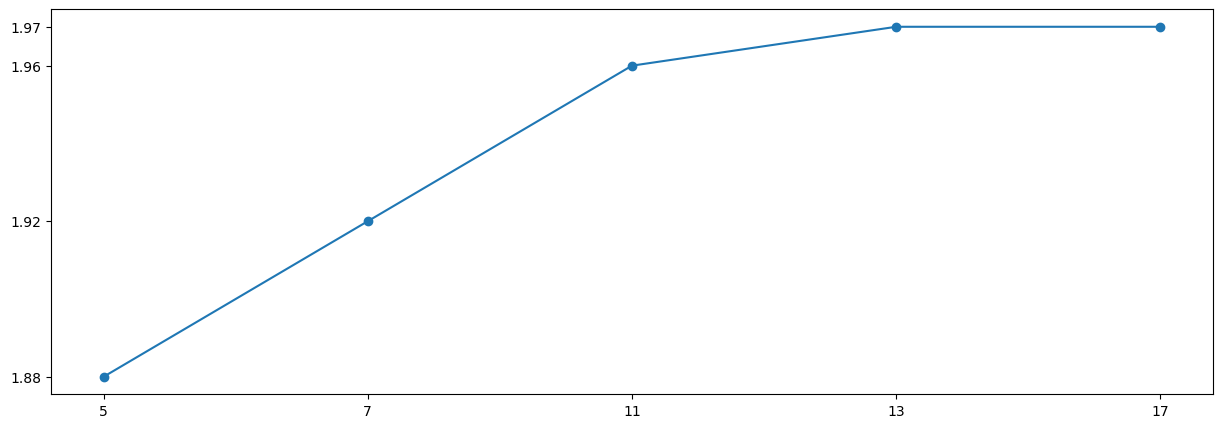

In [11]:
# import matplotlib.pyplot as plt
# 
# fig = plt.figure(figsize=(15, 5))
# plt.plot(list(range(len(prime_arr))), [1.88, 1.92, 1.96, 1.97, 1.97])
# plt.scatter(list(range(len(prime_arr))), [1.88, 1.92, 1.96, 1.97, 1.97])
# plt.xticks(list(range(len(prime_arr))), prime_arr)
# plt.yticks([1.88, 1.92, 1.96, 1.97])
# plt.title('')
# plt.show()